In [1]:
## Scikit learn libraries
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

## For NLP
from bs4 import BeautifulSoup, Tag    ## Cleaning HTML tags from text
import nltk, string
from nltk.corpus import stopwords 
import re

## Common Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data I/O
import json     ## To convert json raw data to df
import pickle   ## saving the model to disk

import xgboost as xgb
from scipy.stats import uniform, randint

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

## Problem texts can be long and may not load on Jupyter
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


## Extract subject wise training data

In [2]:
# Load the dataset and show sample question
with open('../data/qs_topicwise.json') as json_data:
    all_questions = json.load(json_data)

subject_model = ['CHM']

## Create empty df 
data_df = pd.DataFrame(columns=['code', 'curriculum', 'subject', 'grade', 'question_text', 'chapter'])

## Removing these words improves Phy clf accuracy by 2% but improves Math classifier accuracy
words_to_remove = ["rightarrow", "hence", "frac", "text", "sqrt", "times", 
                   "value", "amp", "statement", "will", "equal", "number", 
                   "tan", "now", "can", "two", "get", "true", "lambda", "a", "an", "the"]
stop_words = stopwords.words('english')         ## Downloaded from NLTK
'''
for PHY - removing Stopwords reduce acc & f1 score : 67% -> 63%, 74% -> 72%
for CHM - removing Stopwords reduce acc & f1 score by 6%
for MTH - 
'''

## Remove dummy and empty chapters
chapters_to_remove = ['Selection Test', 'Repository', 'Bridge Intervention Curriculum', 
                      'M1.1 Scaffold test', 'Tally Marks', 'Dummy']
chapters_with_no_data = ['Static Electricity', 'Experimental Skills', 'Nuclear Chemistry', 
                         'Principle of Mathematical Induction', 'Environmental Chemistry']

## Regex pattern for alpha numeric - Improves accuracy & f1-score for Phy by 2%
pattern = re.compile('[\W_]+')

i = 0
for question in all_questions:
    try: 
        question_text = question['question_text'].lower()
        ## Remove HTML tags from text using Beautiful Soup
        '''
        For MTH, it improves accuracy from 40% to 60% in MTH, 
        For PHY, it reduces accuracy from 60% to 20%. 
        For CHM, it increases accuracy from 50% to 52% 
        '''
        question_text = BeautifulSoup(question_text, "html.parser").get_text() 
        ## Remove numbers
        '''
        For PHY, removing nos improved accuracy & F1 score by 0.5%
        For CHM, removing nos improved acc by 2%
        '''
        question_text = ''.join(c for c in question_text if not c.isdigit())
        ## Regex pattern for alpha numeric text
        '''
        For CHM, removing this regex improved score by 9%
        '''
        question_text = pattern.sub(" ", question_text)
        ## Remove stop words
        '''
        For CHM, keeping both sets of words, instead of removing them improved acc by 5%
        '''
        #question_text = " ".join([word for word in question_text.split() if word not in words_to_remove])
        #question_text = " ".join([word for word in question_text.split() if word not in stop_words])
        ## Remove extra whitespaces
        question_text = " ".join(question_text.split()) 
        ## Extracting elements for cleaner code
        grade = question['grade']
        curriculum = question['curriculum']
        chapter = question['chapter']
        subject = question['subject']
        ## Filtering each question from JSON to add relevant Qs to dataframe 
        if(    "JEE" in curriculum and grade in ["11", "12"] and
               chapter not in chapters_to_remove and
               chapter not in chapters_with_no_data and
               "dummy" not in question_text and subject in subject_model):
                data_df.loc[i] = [question['problem_code'],curriculum, subject, \
                                  grade, question_text, chapter]
                i += 1
    except:
            pass

trainDF = pd.DataFrame(columns=['text', 'label'])
trainDF['text'] = data_df['question_text']
trainDF['label'] = data_df['chapter']
trainDF.head(3)

,text,label
0,which of the following statements is incorrect,Solutions
1,dry air was successively passed through a solution of g solute in g water and through pure water the loss in weight of solution was g and that of pure water was g molecular weight of solute in g mol is m find the value of frac m assume that solute is non volatile and does not dissociate or associate,Solutions
2,an aqueous solution boils at k what is the freezing point of the same solution given k f circ c m and k b circ c m,Solutions


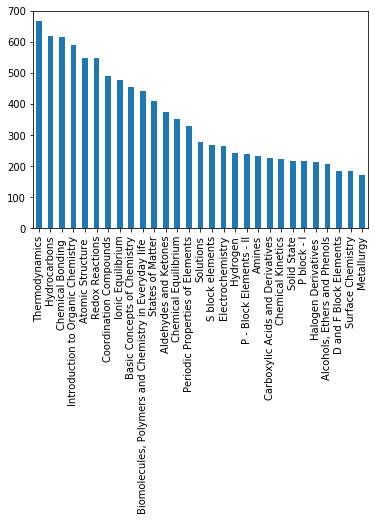

In [3]:
trainDF.label.value_counts().plot(kind="bar")

## Train test split

In [4]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'], test_size=0.2)
print(len(train_x), len(valid_x) )

8220 2055


## Create pipeline for vectorizer & classifier

#### Label Encoding
Label encoding is not needed for sklearn classifiers, as they are all capable of mutli-class classification, and handle label encoding automatically. Source :  https://stackoverflow.com/questions/51525043/encoding-labels-for-multi-class-problems-in-sckit-learn

For non-sklearn models like NNs or XGB, we need to do label encoding

In [5]:
'''
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_y)
train_y = encoder.transform(train_y)
valid_y = encoder.transform(valid_y)
valid_y[0:5]
'''

'\n# Use sklearn utility to convert label strings to numbered index\nencoder = LabelEncoder()\nencoder.fit(train_y)\ntrain_y = encoder.transform(train_y)\nvalid_y = encoder.transform(valid_y)\nvalid_y[0:5]\n'

In [6]:
'''
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)
'''

'\n# Converts the labels to a one-hot representation\nnum_classes = np.max(y_train) + 1\ny_train = utils.to_categorical(y_train, num_classes)\ny_test = utils.to_categorical(y_test, num_classes)\n'

In [7]:
## Custom Tokenizer for Vectorizer (no default by sklearn)
'''
for PHY - improves accuracy & f1 score by 2%
for CHM - improves by 5%
'''
stemmer = nltk.stem.porter.PorterStemmer()    ## May need to download this with "nltk.download('punkt')"
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.translate(remove_punctuation_map)))

## Initializing vectorizer
vec = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3),
                      lowercase=True, tokenizer=normalize, max_features=10000, 
                      use_idf = True, min_df = 5, max_df = 0.8, stop_words = None)
## Can't add stop words here as the text is normalized and it won't match the stop words list. Should remove earlier.
## https://stackoverflow.com/questions/57340142/user-warning-your-stop-words-may-be-inconsistent-with-your-preprocessing

## Initializaing classifier
#clf = naive_bayes.MultinomialNB(alpha=0.3)                                          ## Accuracy 56% 
#clf = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg', C=7.5)   ## Accuracy 57.9%
#clf = xgb.XGBClassifier(objective="multi:softprob", random_state=42, 
#                        learning_rate=0.3, n_estimators=150)                           ## Acc 53%
#clf = RandomForestClassifier(n_estimators=120, max_depth=20, min_samples_leaf=5,      ## Accuracy 27%
#                             max_features=0.6, n_jobs=-1, oob_score=True)      
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4,                               ## Accuracy 58%
                    random_state=42, max_iter=3, tol=None)
## Source : https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

## Setting up pipeline
pipe = make_pipeline(vec, clf)
pipe.fit(train_x, train_y)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=5,
        ngram_range=(2, 3), norm='l2', preprocessor=None, smoot...dom_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

## Prediction & Evaluation metrics

In [8]:
pred_y = pipe.predict(valid_x)
report = metrics.classification_report(valid_y, pred_y)
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(valid_y, pred_y)))
print("F1-score (weighted): {:0.3f}".format(metrics.f1_score(valid_y, pred_y, average = 'weighted')))
## Support is the number of occurrences of each class in valid_y

                                                        precision    recall  f1-score   support

                          Alcohols, Ethers and Phenols       0.29      0.11      0.16        45
                                 Aldehydes and Ketones       0.46      0.36      0.41        72
                                                Amines       0.31      0.33      0.32        27
                                     Atomic Structure        0.70      0.83      0.76       100
                           Basic Concepts of Chemistry       0.55      0.80      0.66        82
Biomolecules, Polymers and Chemistry in Everyday life        0.35      0.62      0.45        80
                      Carboxylic Acids and Derivatives       0.64      0.32      0.43        50
                                     Chemical Bonding        0.61      0.69      0.65       127
                                  Chemical Equilibrium       0.78      0.79      0.78        78
                                     Ch

Need to improve

### Confusion Matrix

In [9]:
metrics.confusion_matrix(valid_y, pred_y)

array([[  5,   5,   3,   0,   0,   4,   1,   3,   0,   1,   1,   0,   0,
          2,  16,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1],
       [  2,  26,   5,   2,   1,   3,   1,   0,   0,   2,   0,   1,   0,
          3,  19,   1,   2,   0,   0,   1,   0,   0,   2,   0,   0,   0,
          0,   1,   0],
       [  0,   1,   9,   0,   0,   2,   2,   0,   0,   0,   0,   0,   0,
          2,   7,   1,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   1],
       [  0,   0,   0,  83,   1,   3,   0,   2,   0,   0,   0,   0,   0,
          0,   1,   0,   1,   0,   0,   0,   0,   4,   0,   0,   1,   1,
          2,   0,   1],
       [  0,   0,   0,   0,  66,   3,   0,   0,   0,   0,   0,   1,   0,
          0,   0,   0,   0,   2,   1,   1,   0,   0,   4,   0,   0,   1,
          1,   1,   1],
       [  0,   4,   1,   0,   2,  50,   1,   4,   0,   0,   2,   0,   0,
          2,   6,   0,   1,   0,   0,   2,   1,   2,   1,   0,   0,   1,
    

#### Chapters that were never predicted

In [10]:
set(valid_y) - set(pred_y)

set()

### Check + and - weights of the model, and which feature contribute to prediction
Manually

In [11]:
'''
for i, tag in enumerate(clf.classes_):
    coefficients = clf.coef_[i]
    weights = list(zip(vec.get_feature_names(),coefficients))
    print('Tag:',tag)
    print('Most Positive Coefficients:')
    print(sorted(weights,key=lambda x: -x[1])[:10])
    print('Most Negative Coefficients:')
    print(sorted(weights,key=lambda x: x[1])[:10])
    print("--------------------------------------")
'''

'\nfor i, tag in enumerate(clf.classes_):\n    coefficients = clf.coef_[i]\n    weights = list(zip(vec.get_feature_names(),coefficients))\n    print(\'Tag:\',tag)\n    print(\'Most Positive Coefficients:\')\n    print(sorted(weights,key=lambda x: -x[1])[:10])\n    print(\'Most Negative Coefficients:\')\n    print(sorted(weights,key=lambda x: x[1])[:10])\n    print("--------------------------------------")\n'

#### +ve and -ve Weights using eli5

In [12]:
import eli5
eli5.show_weights(clf, vec=vec, top=50)

## Misclassified Examples

In [13]:
valid = pd.concat([valid_x, valid_y], axis=1)
valid['pred'] = pred_y
valid.head(10)

,text,label,pred
5460,among the following the least stable resonance structure is,Introduction to Organic Chemistry,Introduction to Organic Chemistry
8862,the units of the vanderwaal s constant b are,States of Matter,Basic Concepts of Chemistry
9751,when two mole of ideal gas c p m r heated from k to k at constant pressure the change in entropy of a gas delta s is,Thermodynamics,Thermodynamics
9880,for a given reaction all the reactants and products are in the same phase,Ionic Equilibrium,Chemical Equilibrium
7485,the product of the reaction is,Hydrocarbons,Hydrocarbons
9874,h o loses h to form oh and also accepts h to form h o which of the following statements are true for oh and h o,Ionic Equilibrium,Hydrogen
5010,write the iupac name of the following compound begin matrix ch ch ch cocl br end matrix,Introduction to Organic Chemistry,Introduction to Organic Chemistry
2762,among the following pairs of complexes in which case the delta value is higher for the first one,Coordination Compounds,Coordination Compounds
3293,on complete hydrogenation natural rubber produces,"Biomolecules, Polymers and Chemistry in Everyday life","Biomolecules, Polymers and Chemistry in Everyday life"
2179,the major product in the following reaction is,Chemical Kinetics,Hydrocarbons


In [14]:
misclassified_examples = valid[valid.label != valid.pred]
misclassified_examples.head()

,text,label,pred
8862,the units of the vanderwaal s constant b are,States of Matter,Basic Concepts of Chemistry
9880,for a given reaction all the reactants and products are in the same phase,Ionic Equilibrium,Chemical Equilibrium
9874,h o loses h to form oh and also accepts h to form h o which of the following statements are true for oh and h o,Ionic Equilibrium,Hydrogen
2179,the major product in the following reaction is,Chemical Kinetics,Hydrocarbons
5233,given reactions r ch br longrightarrow r dot ch dot br delta h r ch ch br longrightarrow r ch dot ch dot br delta h r ch ch ch br longrightarrow r ch ch dot ch dot br delta h arrange the following in the increasing order of enthalpy of reaction,Introduction to Organic Chemistry,Thermodynamics


#### Checking 2nd row

In [15]:
eli5.show_prediction(clf, misclassified_examples['text'].values[1], vec=vec)

### Serialize trained model to disk

In [16]:
## Encoder not needed for sklearn models
##Vectorizer
with open('vec_chm.pkl', 'wb') as f:
    pickle.dump(vec, f, pickle.HIGHEST_PROTOCOL)
## Classifier
with open('clf_chm.pkl', 'wb') as f:
    pickle.dump(clf, f, pickle.HIGHEST_PROTOCOL)
## Repo for similar Qs
with open('repo_chm.pkl', 'wb') as f:
    pickle.dump(data_df, f, pickle.HIGHEST_PROTOCOL)